In [6]:
!nvidia-smi

Wed Sep 16 00:53:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:04:00.0 Off |                  N/A |
| 41%   28C    P8    35W / 280W |     11MiB / 24220MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:05:00.0 Off |                  N/A |
| 41%   35C    P8    22W / 280W |     11MiB / 24220MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
######### IMPORTING NECESSARY MODULES #########
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import sys
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data

import torch.optim as optim

sys.path.append('/home/ironman/abhishek/Fixtures_Data/architectures/')
sys.path.append('/home/ironman/abhishek/Fixtures_Data/Helper/')
from dataloader import mydataset, create_prime_dict 
from ringloss import RingLoss
from cutmix_rl_trainer import train, test_classify, eval_classify
from efficientnet import *
from Load_model import load
from plot_curves import plot_loss, plot_acc

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


**Dataloading Scheme**

In [5]:
trainlist = "/media/Duamutef/abhishek/Z_A/lists/Matches_Crops_Groups_training_list.txt"
validlist ="/media/Duamutef/abhishek/Z_A/lists/Matches_Crops_Groups_validation_list.txt"

In [6]:
prime_dict = create_prime_dict(trainlist)

Number of classes =  467


In [7]:
#### Train Dataloader #### 
train_dataset = mydataset(trainlist, prime_dict, name='train')          
train_dataloader = data.DataLoader(train_dataset, shuffle= True, batch_size = 256, num_workers=16,pin_memory=True)


#### Validation Dataloader #### 
validation_dataset = mydataset(validlist, prime_dict, name='valid')         
validation_dataloader = data.DataLoader(validation_dataset, shuffle=False, batch_size = 128, num_workers=16,pin_memory=True)

**Model Definition**

In [8]:
model = EfficientNet.from_pretrained('efficientnet-b4', num_classes = 467)

model = nn.DataParallel(model,device_ids=[0,1,2,3]).to(device)
model

Loaded pretrained weights for efficientnet-b4


DataParallel(
  (module): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        

**Hyperparameters**

In [9]:
## Loss Function
criterion = nn.CrossEntropyLoss()

ringloss_block = RingLoss(device,loss_weight=1.0)

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4, momentum=0.9)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 30, gamma = 0.1)

# Epochs
num_Epochs = 120

beta=1

cutmix_prob = 1

In [10]:
modelpath = '../saved_model_checkpoints/Fixture_Data/Annotated_MCG_AA_Cutout_Cutmix_RL_EB4'

In [11]:
train(model, train_dataloader, validation_dataloader, beta, cutmix_prob, criterion, optimizer, lr_scheduler,
      ringloss_block, modelpath, device, epochs = num_Epochs)

loss 4.450956676006317
loss 7.572821909189225
loss 10.504093703627586
Epoch:  1
training loss =  3.331199274169213
Validation Loss: 0.8715	Top 1 Validation Accuracy: 0.7908	 Top 5 Validation Accuracy: 0.9517
loss 2.615906575322151
loss 5.128785536289215
loss 7.602964049577713
Epoch:  2
training loss =  2.4856729992709234
Validation Loss: 0.6738	Top 1 Validation Accuracy: 0.8244	 Top 5 Validation Accuracy: 0.9599
loss 2.3296123260259627
loss 4.642784917354584
loss 6.922766246795654
Epoch:  3
training loss =  2.3113899514937275
Validation Loss: 0.6273	Top 1 Validation Accuracy: 0.8355	 Top 5 Validation Accuracy: 0.9643
loss 2.237550303339958
loss 4.441979007720947
loss 6.676688345074654
Epoch:  4
training loss =  2.202379560127308
Validation Loss: 0.5810	Top 1 Validation Accuracy: 0.8524	 Top 5 Validation Accuracy: 0.9687
loss 2.1026046270132066
loss 4.230533173084259
loss 6.351840528249741
Epoch:  5
training loss =  2.1150839121241845
Validation Loss: 0.5685	Top 1 Validation Accuracy: 0

loss 1.3783606320619584
loss 2.785267487168312
loss 4.1997260466218
Epoch:  41
training loss =  1.3945939203051372
Validation Loss: 0.2941	Top 1 Validation Accuracy: 0.9262	 Top 5 Validation Accuracy: 0.9873
loss 1.3147915932536125
loss 2.688384977579117
loss 4.107774037122726
Epoch:  42
training loss =  1.3792338602205845
Validation Loss: 0.2984	Top 1 Validation Accuracy: 0.9260	 Top 5 Validation Accuracy: 0.9857
loss 1.3626784473657607
loss 2.756855511069298
loss 4.117899608910084
Epoch:  43
training loss =  1.3773699100104926
Validation Loss: 0.3035	Top 1 Validation Accuracy: 0.9219	 Top 5 Validation Accuracy: 0.9861
loss 1.3589762470126152
loss 2.7587262079119683
loss 4.1624757674336434
Epoch:  44
training loss =  1.3907218438168472
Validation Loss: 0.2983	Top 1 Validation Accuracy: 0.9237	 Top 5 Validation Accuracy: 0.9862
loss 1.3388509523868561
loss 2.6983745193481443
loss 4.1055572843551635
Epoch:  45
training loss =  1.3683245879505317
Validation Loss: 0.2923	Top 1 Validation 

Validation Loss: 0.2686	Top 1 Validation Accuracy: 0.9348	 Top 5 Validation Accuracy: 0.9881
loss 1.17934864372015
loss 2.4289881873130796
loss 3.6697452902793883
Epoch:  81
training loss =  1.2214390050366286
Validation Loss: 0.2713	Top 1 Validation Accuracy: 0.9331	 Top 5 Validation Accuracy: 0.9884
loss 1.2313804918527602
loss 2.45764390617609
loss 3.6942820605635642
Epoch:  82
training loss =  1.224415148974089
Validation Loss: 0.2708	Top 1 Validation Accuracy: 0.9326	 Top 5 Validation Accuracy: 0.9891
loss 1.1891127744317054
loss 2.4002008765935896
loss 3.643569718301296
Epoch:  83
training loss =  1.2105090421531837
Validation Loss: 0.2693	Top 1 Validation Accuracy: 0.9316	 Top 5 Validation Accuracy: 0.9891
loss 1.1874044197797775
loss 2.36639723777771
loss 3.5267779830098154
Epoch:  84
training loss =  1.1791880927316805
Validation Loss: 0.2772	Top 1 Validation Accuracy: 0.9319	 Top 5 Validation Accuracy: 0.9886
loss 1.2243683713674545
loss 2.4470426559448244
loss 3.639112018048

Validation Loss: 0.2667	Top 1 Validation Accuracy: 0.9354	 Top 5 Validation Accuracy: 0.9881
loss 1.190716197192669
loss 2.3793273344635963
loss 3.588389043211937
Epoch:  120
training loss =  1.194884295472924
Validation Loss: 0.2629	Top 1 Validation Accuracy: 0.9358	 Top 5 Validation Accuracy: 0.9895


In [10]:
#### Load saved model from checkpoint  #####
model, optimizer, lr_scheduler, train_loss, v_loss, v_acc, epoch = load(modelpath, model, optimizer, lr_scheduler)


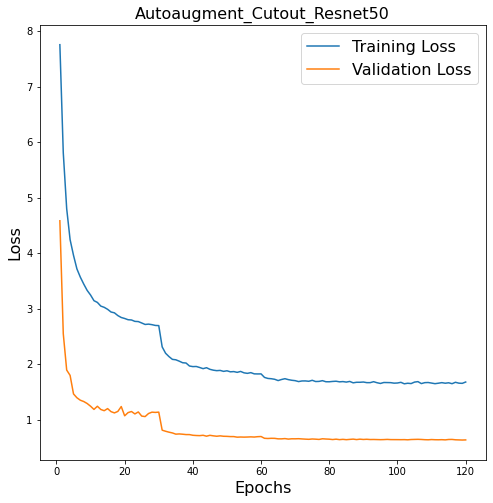

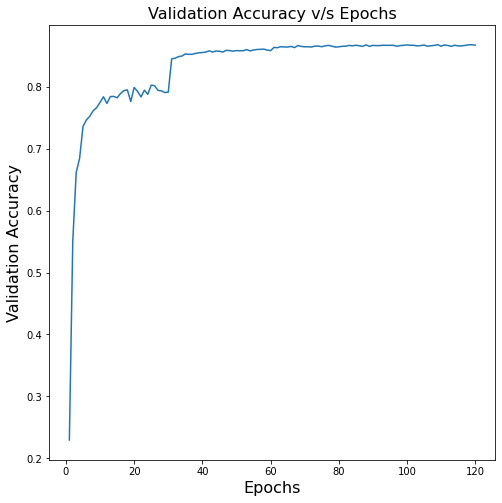

In [11]:
#### Plot Loss Curves ####
plot_loss(epoch, train_loss, v_loss, title = 'Annotated_MCG_AA_Cutout_Cutmix_RL_EB4')
plot_acc(epoch, v_acc)

In [20]:
t_loss,top1_t_acc, top5_t_acc =test_classify(model, train_dataloader, criterion, device)
print('Training Loss: {:.4f}\tTop 1 Training Accuracy: {:.4f}\t Top 5 Training Accuracy: {:.4f}'.format(t_loss, top1_t_acc, top5_t_acc))

Training Loss: 0.4860	Top 1 Training Accuracy: 0.8849	 Top 5 Training Accuracy: 0.9747


In [13]:
v_loss, top1_acc, accuracy_dict= eval_classify(model, validation_dataloader, criterion, device)
print('Validation Loss: {:.4f}\tTop 1 Validation Accuracy: {:.4f}\nAccuracy:{}\t'.format(v_loss, top1_acc, accuracy_dict))

Validation Loss: 0.2642	Top 1 Validation Accuracy: 0.9357
Accuracy:defaultdict(<class 'int'>, {'Top 1 Accuracy': 93.56598626657888, 'Top 5 Accuracy': 98.92766437776315, 'Top 10 Accuracy': 99.32273539648199, 'Top 20 Accuracy': 99.56730316997461, 'Top 30 Accuracy': 99.661367698241, 'Top 50 Accuracy': 99.77424513216067, 'Top 100 Accuracy': 99.85890320760042})	
